In [1]:
import pandas as pd
import numpy as np
import os
import models
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score
from nltk.corpus import stopwords
import re
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
from keras.layers import Input, Dense, Embedding, Flatten, Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.models import Model
from keras.utils import np_utils
from time import time

Using TensorFlow backend.


In [2]:
english_stopwords = set(stopwords.words('english'))
categories = ['Democrat', 'Republican']
tweetsdf = pd.read_csv('democratvsrepublicantweets/ExtractedTweets.csv')
handlesdf = pd.read_csv('democratvsrepublicantweets/TwitterHandles.csv')
raw_tweets = tweetsdf['Tweet']
parties = tweetsdf['Party']
y = 1.0 - np.asarray(parties == 'Democrat')

cv = CountVectorizer(stop_words='english', strip_accents='ascii')
bag_of_words = cv.fit_transform([re.sub(r'https?://[^\s]+', '', tweet) for tweet in raw_tweets])

vocab = {}
for feature, freq in zip(cv.get_feature_names(), bag_of_words.sum(axis=0).tolist()[0]):
    if freq > 10:
        vocab[feature] = freq

vocabulary = list(vocab.keys())
vocabulary_size = len(vocabulary) + 1

word_to_int = {word: i + 1 for i, word in enumerate(vocabulary)}
int_to_word = {i + 1: word for i, word in enumerate(vocabulary)}

encoded_tweets =\
    [[word_to_int.get(word, 0) for word in word_tokenize(re.sub(r'https?://[^\s]+', '', tweet).lower())
      if word in word_to_int]
     for tweet in raw_tweets]

max_tweet_len = max([len(encoded_tweet) for encoded_tweet in encoded_tweets])

X = []
for encoded_tweet in encoded_tweets:
    v = np.zeros(max_tweet_len)
    v[0:len(encoded_tweet)] = encoded_tweet
    X.append(v)
    
X = np.array(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
filepath, model = models.model7(vocabulary_size, max_tweet_len)
if filepath in os.listdir():
    model.load_weights(filepath)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 19)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 19, 100)           842500    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 128)           51328     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)    

In [7]:
# models.train(X_train, y_train, model, 'tmp_' + filepath)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
69168/69168 [==============================] - 6s 85us/step - loss: 0.0160

Epoch 00001: loss improved from inf to 0.01602, saving model to tmp_word-embedding1.hdf5
Epoch 2/100
69168/69168 [==============================] - 6s 91us/step - loss: 0.0156

Epoch 00002: loss improved from 0.01602 to 0.01560, saving model to tmp_word-embedding1.hdf5
Epoch 3/100
69168/69168 [==============================] - 6s 92us/step - loss: 0.0150

Epoch 00003: loss improved from 0.01560 to 0.01502, saving model to tmp_word-embedding1.hdf5
Epoch 4/100
69168/69168 [==============================] - 7s 102us/step - loss: 0.0149

Epoch 00004: loss improved from 0.01502 to 0.01491, saving model to tmp_word-embedding1.hdf5
Epoch 5/100
69168/69168 [==============================] - 7s 105us/step - loss: 0.0152

Epoch 00005: loss did not improve from 0.01491
Epoch 6/100
69168/69168 [==============================] - 8s 115us/step - loss: 0.0150

Epoch 

69168/69168 [==============================] - 7s 97us/step - loss: 0.0122

Epoch 00053: loss improved from 0.01249 to 0.01223, saving model to tmp_word-embedding1.hdf5
Epoch 54/100
69168/69168 [==============================] - 7s 96us/step - loss: 0.0123

Epoch 00054: loss did not improve from 0.01223
Epoch 55/100
69168/69168 [==============================] - 7s 98us/step - loss: 0.0128

Epoch 00055: loss did not improve from 0.01223
Epoch 56/100
69168/69168 [==============================] - 7s 98us/step - loss: 0.0125

Epoch 00056: loss did not improve from 0.01223
Epoch 57/100
69168/69168 [==============================] - 7s 101us/step - loss: 0.0133

Epoch 00057: loss did not improve from 0.01223
Epoch 58/100
69168/69168 [==============================] - 7s 99us/step - loss: 0.0125

Epoch 00058: loss did not improve from 0.01223
Epoch 59/100
69168/69168 [==============================] - 7s 98us/step - loss: 0.0127

Epoch 00059: loss did not improve from 0.01223
Epoch 60/100
6

In [8]:
predictions = np.argmax(model.predict(X_test), axis=1)

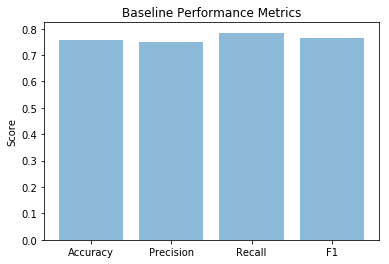

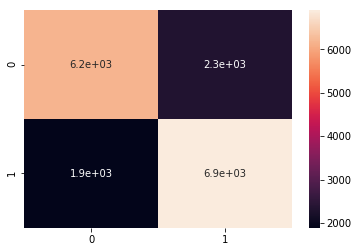

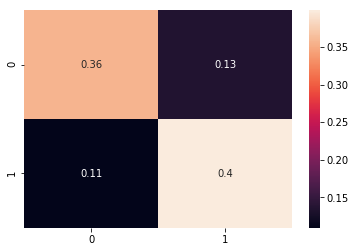

Accuracy: 0.7563034929447143
Accuracy: 0.747939262472885
Accuracy: 0.7848850443888004
Accuracy: 0.7659668999222481


In [9]:
(accuracy, precision, recall, f1), confusion_matrix = models.plot_results(y_test, predictions)
print('Accuracy: %s' % accuracy)
print('Accuracy: %s' % precision)
print('Accuracy: %s' % recall)
print('Accuracy: %s' % f1)